In [11]:
from ntdmc_trachoma.trachoma_functions import *
import multiprocessing
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt

num_cores = multiprocessing.cpu_count()

'''
I don't think you need to change anything on your end except for the betas which is at the bottom. 
The rest of this script is just setting up the population
'''

params = {'N': 2500,
          'av_I_duration' : 2,
          'av_ID_duration':300/7,
          'inf_red':0.45,
          'min_ID':11, #Parameters relating to duration of infection period, including ID period
          'av_D_duration':200/7,
          'min_D':10.1/7, #Parameters relating to duration of disease period
          'dis_red':0.3,
          'v_1':1,
          'v_2':2.6,
          'phi':1.4,
          'epsilon':0.5,#Parameters relating to lambda function- calculating force of infection
          #Parameters relating to MDA
          'MDA_Cov':0.8,
          'MDA_Eff': 0.85, # Efficacy of treatment
          'rho':0.3,
          'nweeks_year':52,
          'babiesMaxAge':0.5, #Note this is years, need to check it converts to weeks later
          'youngChildMaxAge':9,#Note this is years, need to check it converts to weeks later
          'olderChildMaxAge':15, #Note this is years, need to check it converts to weeks later
          'b1':1,#this relates to bacterial load function
          'ep2':0.114,
          'n_inf_sev':38,
          'TestSensitivity': 0.96,
          'TestSpecificity': 0.965,
          'SecularTrendIndicator': 0,
          'SecularTrendYearlyBetaDecrease': 0.01,
          'vacc_prob_block_transmission':  0.5, 
          'vacc_reduce_bacterial_load': 0, 
          'vacc_reduce_duration': 0,
          'vacc_coverage': 0,  
          'vacc_waning_length': 52 * 5,
          'importation_rate': 0.000008,
          'importation_reduction_rate': (0.9)**(1/10),
          'infection_risk_shape':6.4} # extra parameter needed for infection risk shape. equivalent to k in STH/sch model.
                                        #Set to a very high number if you want to assume everyone is the same

sim_params = {'timesim':(52*96)+1,
              'burnin': (52*70)-1,
              'N_MDA': 0} # Set by main script later


demog = {'tau': 0.0004807692, 
         'max_age': 3120,
         'mean_age': 1040}



Start_date = date(1996,1, 1)


def get_Vacc_data(coverageFileName, Start_date, sim_params):
    VaccData = readPlatformData(coverageFileName, "Vaccine")
    Vaccine_dates = getInterventionDates(VaccData)
    vacc_times = get_Intervention_times(Vaccine_dates, Start_date, sim_params['burnin'])
    return VaccData, vacc_times

# function to get the MDA data for the specified coverage file
def get_MDA_data(coverageFileName, Start_date, sim_params):
    MDAData = readPlatformData(coverageFileName, "MDA")
    MDA_dates = getInterventionDates(MDAData)
    MDA_times = get_Intervention_times(MDA_dates, Start_date, sim_params['burnin'])
    return MDAData, MDA_times



def create_initial_population(initial_prevalence: float, MDAData, parameters, distToUse = "Poisson"):
    vals = Set_inits(parameters, demog, sim_params, MDAData, np.random.get_state(), distToUse=distToUse)
    ids = np.random.choice(
        range(parameters["N"]), int(initial_prevalence * parameters["N"]), replace=False
    )
    vals["IndI"][ids] = 1
    vals["T_latent"][ids] = vals["Ind_latent"][ids]
    vals["No_Inf"][ids] = 1
    return vals


def alterMDACoverage(MDAData, coverage):
    """ update the coverage of each MDA for a run to be a given value.
    Parameters
    ----------
    MDAData
        A list of MDA's to be done with date and coverage of the MDA included. 
        The coverage is given by the 4th value within each MDA of MDAData so we update the [3] position.
    coverage    
        The new coverage level for each MDA
    Returns
    -------
    function
        MDAData with updated coverage value
    """
    for MDA in MDAData:
        MDA[3] = coverage
    return MDAData






# read in sampled parameters
simparams = pd.read_csv("sampled_params_5324.csv")
simparams.columns = [s.replace(' ', '') for s in simparams.columns]

# define the lists of random seeds, R0 and k
seeds = simparams.iloc[:, 2].tolist()
betas = simparams.iloc[:, 3].tolist()
coverages = simparams.iloc[:, 4].tolist()

# what proportion of the population should begin infected
initial_infect_frac = 0.1

# generate MDA and vaccination data from the scenario file
MDAData, MDA_times = get_MDA_data("scen1.csv", Start_date, sim_params)
VaccData, vacc_times = get_Vacc_data("scen1.csv", Start_date, sim_params)

# specify that we want yearly output from the model
outputYear = range(1996, 2021)
outputTimes = getOutputTimes(outputYear)
outputTimes = get_Intervention_times(outputTimes, Start_date, sim_params['burnin'])

# extra functions to generate data we need for the runs and to run and plot the simulations



# This is so that we use exponentially distributed times rather than poisson.
# I think you have been doing this recently
distToUse = "Expo"


# set up population

seed = 100
np.random.seed(seed)
vals = create_initial_population(initial_infect_frac, MDAData, params, distToUse)
random_state = np.random.get_state()

timesim = sim_params['timesim']
burnin = sim_params['burnin']



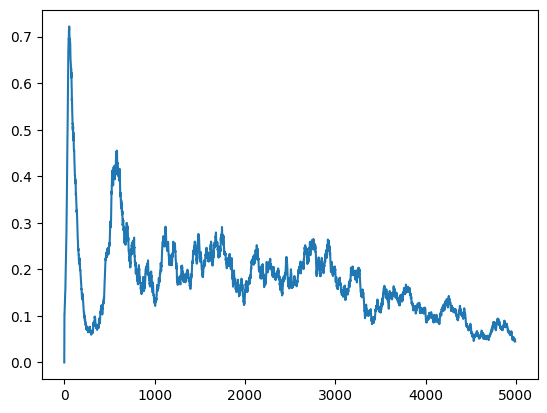

In [12]:

'''
here you specify what you want to do with the yearly beta values. 
the length should be int(sim_params['timesim']/52)

so I think for the amis code, you need to do 

beta=amisPars[0:(int(sim_params['timesim']/52)-1)]

'''
#betas = np.random.uniform(0.1, 0.2, size = int(sim_params['timesim']/52))
betas = np.linspace(0.1, 0.04, int(sim_params['timesim']/52))

out, _ = sim_Ind_MDA_Include_Survey(params, vals, timesim, burnin, demog, betas, MDA_times, MDAData, vacc_times,  VaccData, outputTimes,
                                    doSurvey = False, doIHMEOutput= False, numpy_state = random_state, distToUse = distToUse)

plt.plot(out['True_Prev_Disease_children_1_9'])
